In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pycocotools
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import yaml
import torch
import shutil
import wandb

%matplotlib inline

C:\Users\Sourabh\AppData\Roaming\Python\Python311\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [23]:
train_imgs_dir="training_images"
train_labels="train_solution_bounding_boxes (1).csv"

test_imgs_dir="testing_images"

In [4]:
imgs_list=list(sorted(os.listdir(train_imgs_dir)))
idxs=list(range(len(imgs_list)))
np.random.shuffle(idxs)

train_idx=idxs[:int(0.8*len(idxs))]
val_idx=idxs[int(0.8*len(idxs)):]

In [5]:
!mkdir "working/data"

# images directory 
!mkdir "working/data/images"

# train and test subdirectories with image directory
!mkdir "working/data/images/train"
!mkdir "working/data/images/val"

# labels directory
!mkdir "working/data/labels"

# train and test subdirectories with labels directory
!mkdir "working/data/labels/train"
!mkdir "working/data/labels/val"

A subdirectory or file working/data already exists.
A subdirectory or file working/data/images already exists.
A subdirectory or file working/data/images/train already exists.
A subdirectory or file working/data/images/val already exists.
A subdirectory or file working/data/labels already exists.
A subdirectory or file working/data/labels/train already exists.
A subdirectory or file working/data/labels/val already exists.


In [6]:
root_dir="working/data"
labels_dir="working/data/labels"
images_dir="working/data/images"

In [7]:
df=pd.read_csv(train_labels)

width=676
height=380

df["class"]=0
df.rename(columns={'image':'img_name'}, inplace=True)

df["x_centre"]=(df["xmin"]+df["xmax"])/2
df["y_centre"]=(df["ymin"]+df["ymax"])/2
df["width"]=(df["xmax"]-df["xmin"])
df["height"]=(df["ymax"]-df["ymin"])

#normalizing bounding box coordinates
df["x_centre"]=df["x_centre"]/width
df["y_centre"]=df["y_centre"]/height
df["width"]=df["width"]/width
df["height"]=df["height"]/height

df_yolo=df[["img_name","class","x_centre","y_centre","width","height"]]
df_yolo.head()

,img_name,class,x_centre,y_centre,width,height
0,vid_4_1000.jpg,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000.jpg,0,0.100217,0.557191,0.155572,0.129987
2,vid_4_10040.jpg,0,0.444645,0.543678,0.181621,0.157014
3,vid_4_10020.jpg,0,0.833213,0.531451,0.197540,0.155727
4,vid_4_10060.jpg,0,0.110347,0.559122,0.171491,0.136422


In [ ]:
for idx,img_name in enumerate(imgs_list):
    subset="train"
    if idx in val_idx:
        subset="val"
        
    if np.isin(img_name,df_yolo["img_name"]):
        columns=["class","x_centre","y_centre","width","height"]
        img_bbox=df_yolo[df_yolo["img_name"]==img_name][columns].values
        
        label_file_path=os.path.join(labels_dir,subset,img_name[:-4]+".txt")
        with open(label_file_path,"w+") as f:
            for row in img_bbox:
                text=" ".join(row.astype(str))
                f.write(text)
                f.write("\n")
                
    old_image_path=os.path.join(train_imgs_dir,img_name)
    new_image_path=os.path.join(images_dir,subset,img_name)
    shutil.copy(old_image_path,new_image_path)
    

In [ ]:
yolo_format = dict(
    path="C:/Users/Sourabh/Downloads/data/working/data",  # Full absolute path!
    train="C:/Users/Sourabh/Downloads/data/working/data/images/train",
    val="C:/Users/Sourabh/Downloads/data/working/data/images/val",
    nc=1,
    names={0: "car"}
)

# Save YAML correctly
with open('working/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)
    


In [ ]:
model = YOLO('yolov8m.pt')
model.train(data='working/yolo.yaml', epochs=6, patience=5, batch=8, lr0=0.0001, imgsz=450,device='cpu',workers=4)

In [14]:
model = YOLO("runs/detect/train16/weights/best.pt")
metrics = model.val(data="working/yolo.yaml", imgsz=450, batch=8, device="cpu", workers=4)


WARNING  imgsz=[450] must be multiple of max stride 32, updating to [480]
Ultralytics 8.3.104  Python-3.11.11 torch-2.6.0+cpu CPU (AMD Ryzen 5 5500U with Radeon Graphics)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning C:\Users\Sourabh\Downloads\data\working\data\labels\val.cache... 176 images, 310 backgrounds, 0 corrupt: 100%|██████████| 486/486 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [01:30<00:00,  1.48s/it]


                   all        486        285      0.965      0.967       0.99      0.657
Speed: 1.1ms preprocess, 176.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\val


In [20]:
path_best_weights="runs/detect/train16/weights/best.pt"
model = YOLO(path_best_weights) 

metrics = model.val() 

Ultralytics 8.3.104  Python-3.11.11 torch-2.6.0+cpu CPU (AMD Ryzen 5 5500U with Radeon Graphics)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning C:\Users\Sourabh\Downloads\data\working\data\labels\val.cache... 176 images, 310 backgrounds, 0 corrupt: 100%|██████████| 486/486 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [01:31<00:00,  2.96s/it]


                   all        486        285      0.965      0.967       0.99      0.657
Speed: 1.2ms preprocess, 178.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\val2


In [21]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.6571323377552086
Mean Average Precision @ .50   : 0.9901874958609947
Mean Average Precision @ .70   : 0.7862772436870749


In [24]:
with torch.no_grad():
    results=model.predict(source=test_imgs_dir,conf=0.50,iou=0.75)


image 1/175 c:\Users\Sourabh\Downloads\data\testing_images\vid_5_25100.jpg: 288x480 (no detections), 427.0ms
image 2/175 c:\Users\Sourabh\Downloads\data\testing_images\vid_5_25120.jpg: 288x480 (no detections), 194.1ms
image 3/175 c:\Users\Sourabh\Downloads\data\testing_images\vid_5_25140.jpg: 288x480 (no detections), 224.9ms
image 4/175 c:\Users\Sourabh\Downloads\data\testing_images\vid_5_25160.jpg: 288x480 (no detections), 214.1ms
image 5/175 c:\Users\Sourabh\Downloads\data\testing_images\vid_5_25180.jpg: 288x480 (no detections), 213.6ms
image 6/175 c:\Users\Sourabh\Downloads\data\testing_images\vid_5_25200.jpg: 288x480 (no detections), 215.5ms
image 7/175 c:\Users\Sourabh\Downloads\data\testing_images\vid_5_25220.jpg: 288x480 (no detections), 219.7ms
image 8/175 c:\Users\Sourabh\Downloads\data\testing_images\vid_5_25240.jpg: 288x480 (no detections), 221.6ms
image 9/175 c:\Users\Sourabh\Downloads\data\testing_images\vid_5_25260.jpg: 288x480 (no detections), 226.4ms
image 10/175 c:\Us

In [27]:
!mkdir "working/predictions"
prediction_dir="working/predictions"

A subdirectory or file working/predictions already exists.


In [28]:
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xyxy.cpu().numpy()
        scores=result.boxes.conf.cpu().numpy()
        
        test_img_list.append(name)
        
        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for score,box in zip(scores,boxes):
                text=f"{score:0.4f} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

In [29]:
def show_bbox(img,boxes,scores,axis,color=(0,255,0)):
    boxes=boxes.astype(int)
    scores=scores
    img=img.copy()
    for i,box in enumerate(boxes):
        score=f"{scores[i]:.4f}"
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,score,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    
    axis.imshow(img)
    axis.axis("off")

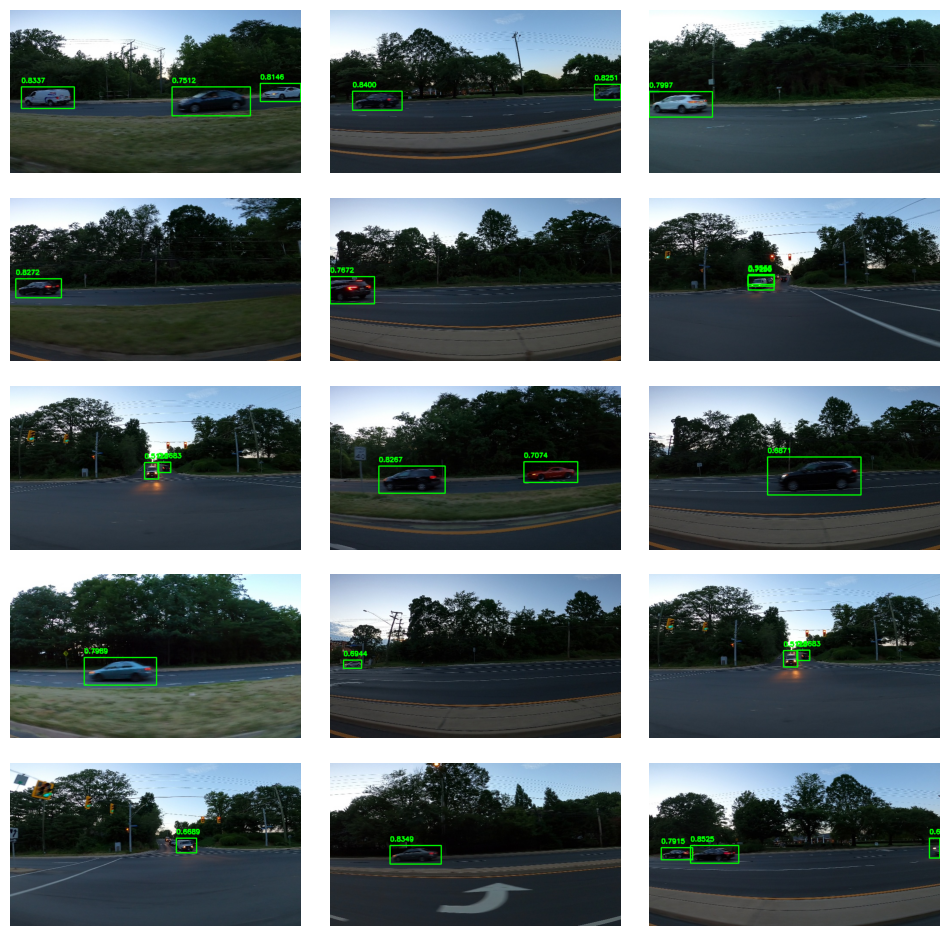

In [30]:
fig,axes=plt.subplots(5,3,figsize=(12,12))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

imgs_name=np.random.choice(test_img_list,15)

for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join(test_imgs_dir,img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    label_file_path=os.path.join(prediction_dir,img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ",header=None).values
    scores=label[:,0]
    boxes=label[:,1:]
    show_bbox(img,boxes,scores,axis=ax[i])
    
plt.savefig("car.png")